In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress ba

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

print(f"Using device {device}")

Using device cuda


In [4]:
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)
with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)
with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

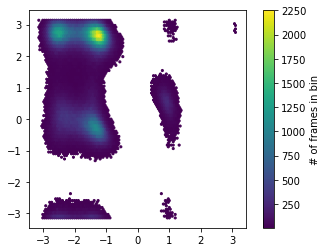

In [5]:
f, ax = plt.subplots(1, 1)
hb = ax.hexbin(*np.concatenate(dihedral).T, mincnt=5)
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

In [6]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

dataset = TrajectoriesDataset.from_numpy(1, data)

In [7]:
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

In [8]:
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),
    nn.Linear(data[0].shape[1], 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe = lobe.to(device=device)
print(lobe)

Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=6, bias=True)
  (12): Softmax(dim=1)
)


In [9]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

In [10]:
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [11]:
model = vampnet.fit(loader_train, n_epochs=30,
                    validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]

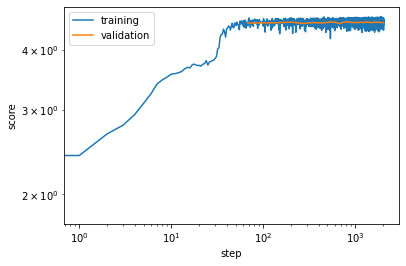

In [12]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();